Attempting to fit house prices, using the [Filght fare](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares)

Imports

In [84]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

# import warnings
# warnings.filterwarnings("ignore")

1. Introducing the House prices dataset -- Exploratory Data Analysis (EDA),

In [85]:
dtf = pd.read_csv("./data/data_airfare.csv")

In [86]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

In [87]:
cols = ["Date_of_journey","Journey_day","Airline","Flight_code","Class","Source","Departure","Total_stops",
        "Arrival","Destination", "Duration_in_hours", "Days_left", "Fare"]
dtf = dtf[cols]

In [88]:
dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [89]:
dtf.describe()

,Duration_in_hours,Days_left,Fare
count,452088.000000,452088.000000,452088.000000
mean,12.349222,25.627902,22840.100890
std,7.431478,14.300846,20307.963002
min,0.750000,1.000000,1307.000000
25%,6.583300,13.000000,8762.750000
50%,11.333300,26.000000,13407.000000
75%,16.500000,38.000000,35587.000000
max,43.583300,50.000000,143019.000000


Value Histograms for Categorical Variables

Examining the target feature - "SalePrice": Using a histogram, a KDE plot, and a box plot

<Axes: >

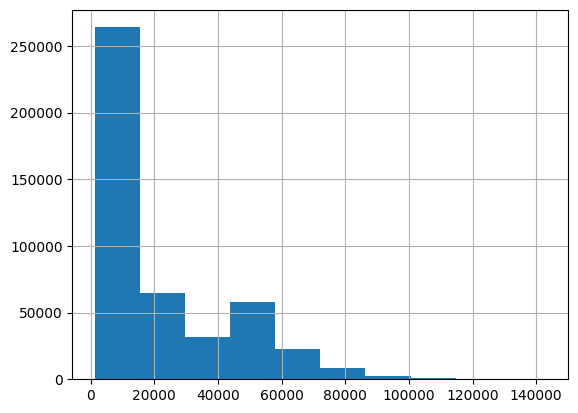

In [90]:
dtf.Fare.hist()

x: the flight fare 
y: the amount of flights of each fare range

Exploring tickets fare:
From the table above we learn that the minimum ticket fare is 1,307 and maximum is 143,019. There exists differnce in mean and median values as well. Let's visualize the price column using a box plot.

<Axes: xlabel='Fare', ylabel='Density'>

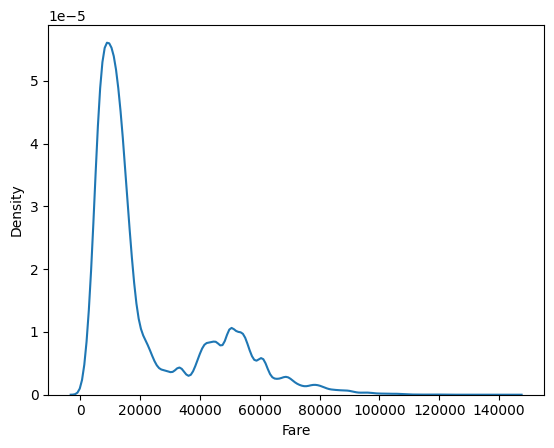

In [91]:
sns.kdeplot(dtf.Fare)

We can see that the data may contains outliers.

Examining outliers

<Axes: xlabel='Fare'>

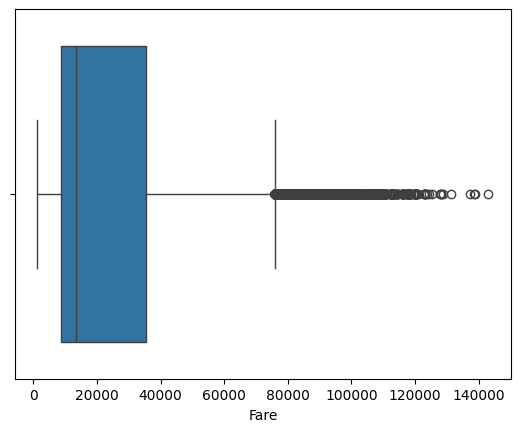

In [92]:
sns.boxplot(dtf.Fare, orient="h")

Price outlier is acceptable because there are different ticket classes like - Economy, Premium Economy, Business and First class.Even though the mean is around 20000, we can see here that the median is approximately 14000. On the First graph, we can see that the dispersion seems to be composed by two gaussian curves. From 1,000 to 30,000 there is one peak, corresponding to the cheap tickets and the second peak from 40,000 to 80,000 corresponding to the expensive class tickets.

So we have decided not to remove the price outliers.

Exploration of the data and understanding the relationships between the different features in the dataset.(copy from ido)

Cleaning and Preprocessing

Making sure there are no null values in our data.

In [93]:
dtf.isnull().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

There are no missing values in our dataset.

In [94]:
#Checking duplicates
dtf.duplicated().sum()

6722

There are 6722 duplicated rows. So let's remove them.

In [95]:
dtf = dtf.drop_duplicates()

In [96]:
#check that the duplicates are gone
dtf.duplicated().sum()

0

In [97]:
# Change the column  from 'Days_left' to 'Advance_purchase_days' for clearity
dtf.rename(columns={'Days_left': 'Advance_days'}, inplace=True)

In [98]:
#check distinct values of departure and arrival cloumns
dtf['Departure'].unique()

array(['After 6 PM', 'Before 6 AM', '12 PM - 6 PM', '6 AM - 12 PM'],
      dtype=object)

In [99]:
dtf['Arrival'].unique()

array(['After 6 PM', 'Before 6 AM', '6 AM - 12 PM', '12 PM - 6 PM'],
      dtype=object)

In [100]:
#convert the departure and arrival columns to time 

# Function to map departure time ranges to categories
def map_departure_time_range(departure_time):
    if 'Before 6 AM' in departure_time:
        return 'Early morning'
    elif '6 AM - 12 PM' in departure_time:
        return 'morning'
    elif '12 PM - 6 PM' in departure_time:
        return 'noon'
    else:
        return 'night'

# Apply the function to the columns
dtf['Departure'] = dtf['Departure'].apply(map_departure_time_range)
dtf['Arrival'] = dtf['Arrival'].apply(map_departure_time_range)

dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Advance_days,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,night,non-stop,night,Mumbai,2.1667,1,5955


In [101]:
# Convert the "Date_of_journey" column to datetime format
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])

# Extract the month from the dates
dtf['Month'] = dtf['Date_of_journey'].dt.month

# Group the flights by month and count the number of flights in each month
dtf.groupby('Month').size()

Month
1    140370
2    251603
3     53393
dtype: int64

<Axes: title={'center': 'Flights monthly variations'}, xlabel='Relative frequencies'>

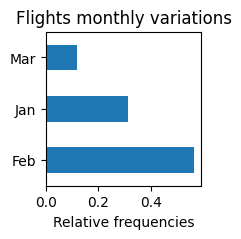

In [102]:
Month_ = pd.to_datetime(dtf.Date_of_journey.values).month
pd.Series(Month_.value_counts(normalize = True).values,index=["Feb","Jan","Mar"]).\
    plot(kind="barh",title="Flights monthly variations", figsize = [2,2], xlabel = "Relative frequencies")

<Axes: title={'center': 'Flights daily variations'}, xlabel='Relative frequencies', ylabel='Journey_day'>

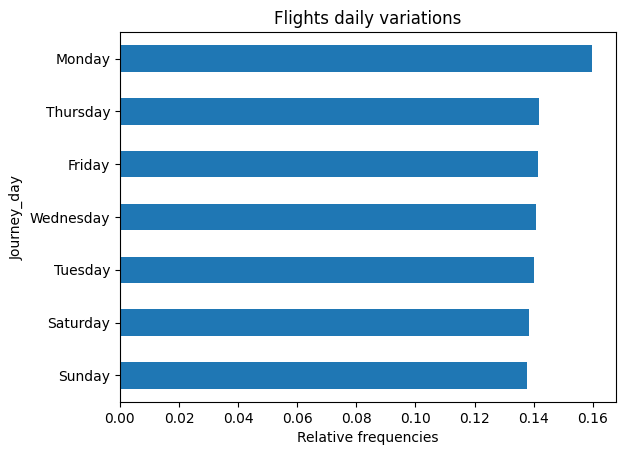

In [103]:
dtf.Journey_day.value_counts(normalize = True, ascending = True).plot(kind="barh",
 title = "Flights daily variations",xlabel = "Relative frequencies")

Given the daily variations observed in the dataset, with flights evenly distributed across the seven weekdays. We want to make sure that the frequencies of values in our training and test sets reflect the daily variations reported in the original dataset. Therefore, we'll apply a stratified split based on this feature later when we split the data into train and test set.

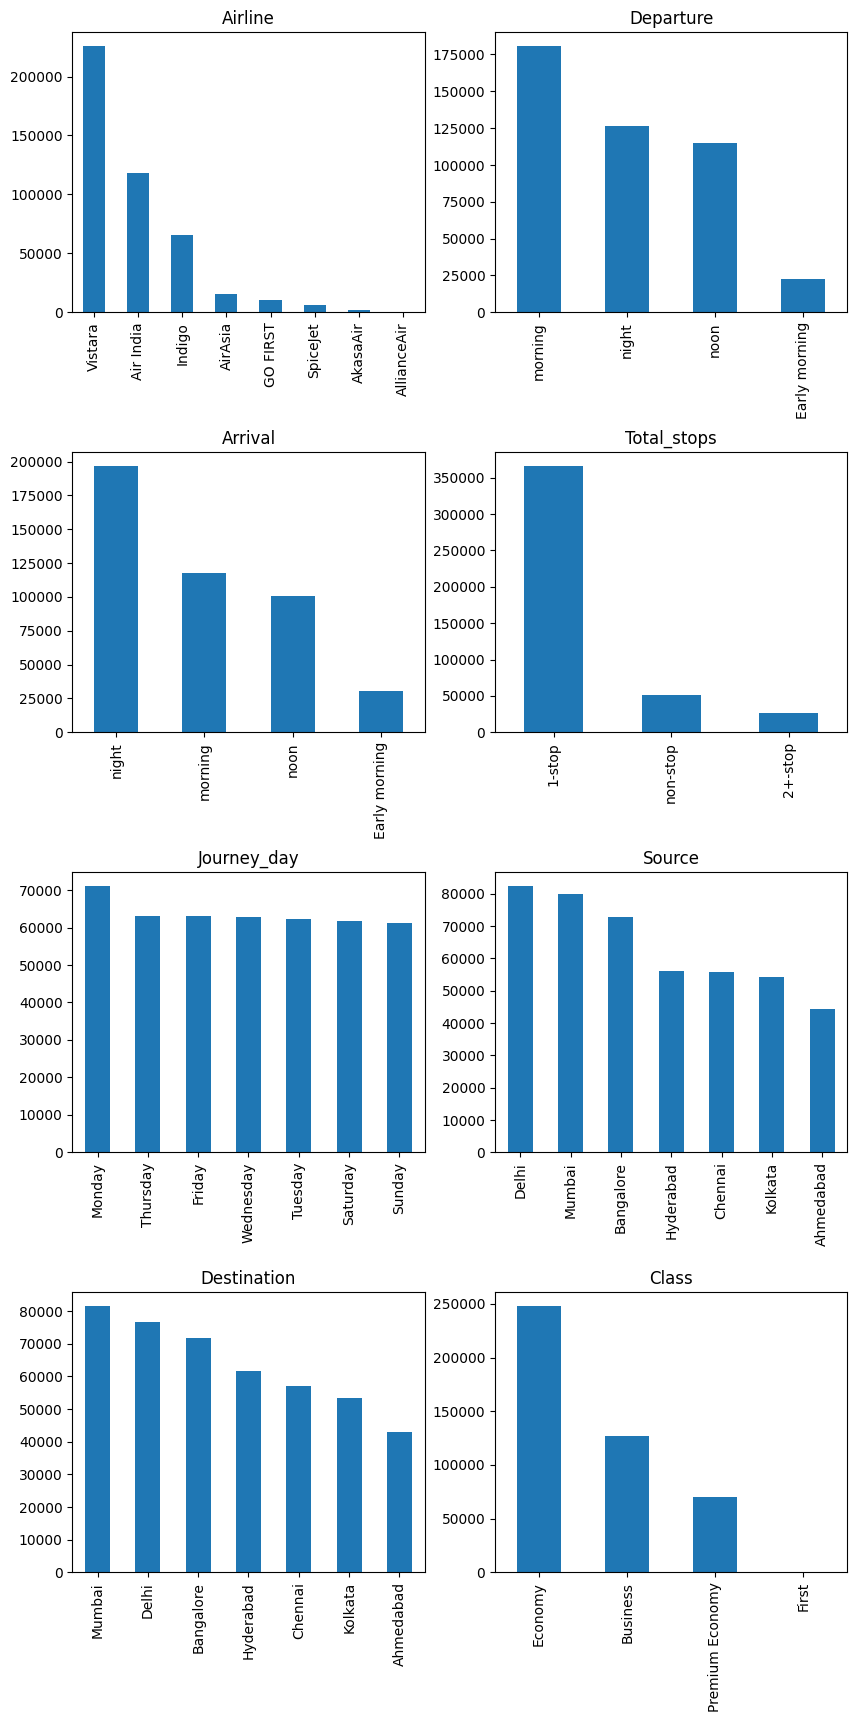

In [104]:
#we will create a histogram for each categorical attribute

# Define the names of categorical columns to remove
columns_to_remove = ["Date_of_journey", "Flight_code"]

# Define the desired order of categorical columns
desired_order = ["Airline", "Departure", "Arrival", "Total_stops", "Journey_day", "Source", "Destination", "Class"]

# Filter categorical columns based on the condition and desired order
categorical_columns_filtered = [c for c in desired_order if c not in columns_to_remove]
                                
n = len(categorical_columns_filtered)
cols = 2
max_bars = 8

rows = (n // cols) + (1 if n % cols != 0 else 0)

#generate a figures grid:
fig, axes = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
fig.subplots_adjust(hspace=0.5)

for i,column in enumerate(categorical_columns_filtered):
    #calculate the current place on the grid
    r=int(i/cols)
    c=i%cols
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(dtf[column].nunique(),max_bars)
    vc = dtf[column].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=column)
    axes[r, c].set_xlabel('')


<Axes: >

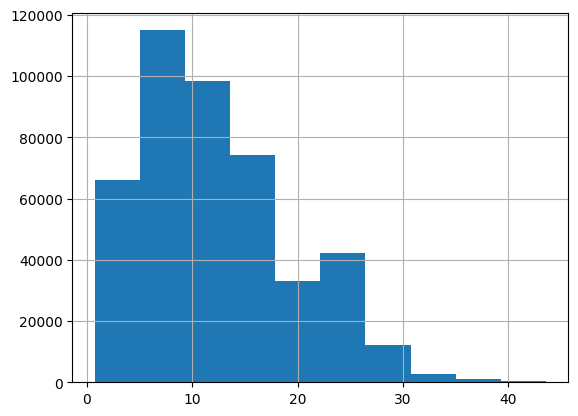

In [105]:
#we will create a histogram for each numeric attribute
dtf.Duration_in_hours.hist()

<Axes: >

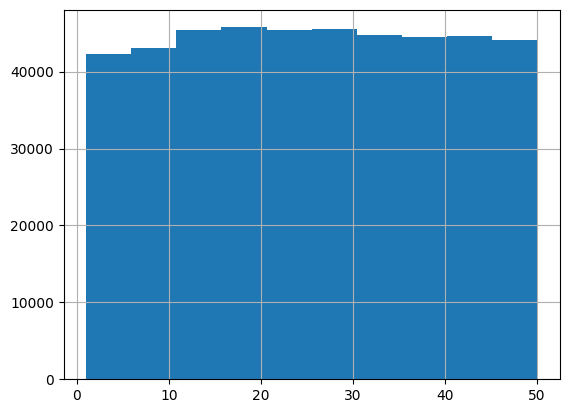

In [106]:
dtf.Advance_days.hist()

In [107]:
data = dtf.groupby("Destination")["Arrival"].value_counts()
data.head(28)

Destination  Arrival      
Ahmedabad    night            20133
             morning          12197
             noon              9773
             Early morning      927
Bangalore    night            32875
             morning          21241
             noon             12845
             Early morning     4642
Chennai      night            26399
             morning          16590
             noon             10751
             Early morning     3320
Delhi        night            29925
             noon             21786
             morning          16890
             Early morning     8157
Hyderabad    night            24154
             noon             17376
             morning          15319
             Early morning     4926
Kolkata      night            26829
             morning          16127
             noon              8356
             Early morning     2153
Mumbai       night            36657
             noon             19435
             morning          19301
 

Examining Correlations to the target feature:

<Axes: >

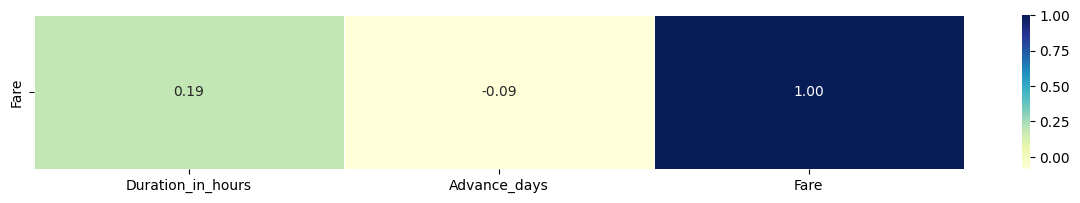

In [113]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
numeric_columns = dtf[numeric_columns]
dtf_corr = numeric_columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)